# from nacer-play

In [ ]:
import umap # pacmap
import pacmap # pacmap
import phate # pacmap

embedding = pacmap.PaCMAP(n_neighbors=1000, verbose=True).fit_transform(all_states_flat)
#embedding = phate.PHATE(knn=1000, t=3, n_jobs=-1, verbose=True).fit_transform(all_states_flat)
#embedding = umap.UMAP(n_neighbors=1000, n_jobs=-1, low_memory=False, verbose=True).fit_transform(all_states_flat)

X is normalized
PaCMAP(n_neighbors=1000, n_MN=500, n_FP=2000, distance=euclidean, lr=1.0, n_iters=450, apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((64521000, 2), (32260500, 2), (129042000, 2))
Initial Loss: 14680064.0
Iteration:   10, Loss: 27617516.000000
Iteration:   20, Loss: 26043624.000000
Iteration:   30, Loss: 25368352.000000
Iteration:   40, Loss: 24548112.000000
Iteration:   50, Loss: 24118116.000000
Iteration:   60, Loss: 23782808.000000
Iteration:   70, Loss: 23324812.000000
Iteration:   80, Loss: 22242586.000000
Iteration:   90, Loss: 20879262.000000
Iteration:  100, Loss: 17348192.000000
Iteration:  110, Loss: 22458148.000000
Iteration:  120, Loss: 22372694.000000
Iteration:  130, Loss: 22203564.000000
Iteration:  140, Loss: 22244220.000000


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=200)

cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
for i in range(0, N_states):
    offset=0
    for j in range(0, i-1):
        offset+=len(all_states[j])
    #im  = ax.plot(*embedding[offset:offset+len(all_states[i]), :].T, color="k", lw=0.1)
    im  = ax.scatter(*embedding[offset:offset+len(all_states[i]), :].T, s=5,
                     c=np.arange(0, len(all_states[i]), 1), cmap="bwr")

plt.colorbar(im)
#plt.show()
plt.savefig("tmp_pmap.png")

In [ ]:
import umap # pacmap
import pacmap # pacmap
import phate # pacmap


embedding = phate.PHATE(n_components=3, knn=1000, t=3, verbose=True).fit_transform(all_states_flat)


In [ ]:
fig = plt.figure(figsize=(9, 9), dpi=100)
ax = fig.add_subplot(projection='3d')

for i in range(0, N_traj):
    offset=0
    for j in range(0, i-1):
        offset+=len(all_states[j])
    #im  = ax.plot(*embedding[offset:offset+len(all_states[i]), :].T, color="k", lw=0.01)
    im  = ax.scatter(*embedding[offset:offset+len(all_states[i]), :].T, s=5,
                     c=np.arange(0, len(all_states[i]), 1), cmap="bwr")


ax.view_init(50, 0)


def update(t):
    print(t)
    ax.view_init(50, t)

    return im,

ani = anim.FuncAnimation(fig, update, frames=180, interval=100, blit=True)
ani.save("3d_phate_5-peaks.mp4")


#plt.colorbar(im)
plt.show()

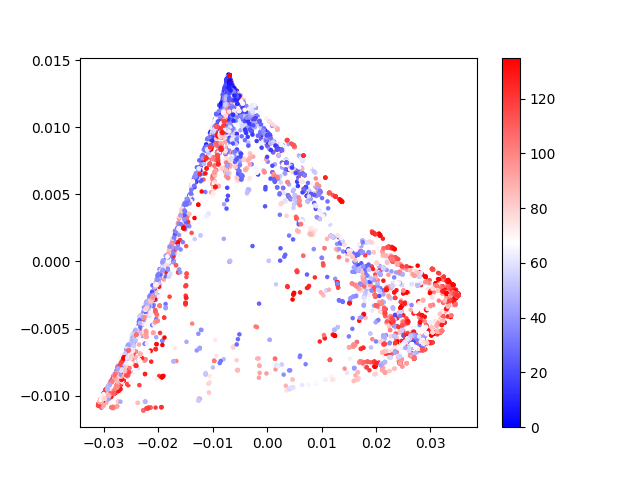

In [ ]:
fig, ax = plt.subplots(1, 1)

for i in range(0, N_traj):
    offset=0
    for j in range(0, i-1):
        offset+=len(all_states[j])
    #im  = ax.plot(*embedding[offset:offset+len(all_states[i]), :].T, color="k", lw=0.01)
    im  = ax.scatter(*embedding[offset:offset+len(all_states[i]), :].T, s=5,
                     c=np.arange(0, len(all_states[i]), 1), cmap="bwr")

plt.colorbar(im)
plt.show()

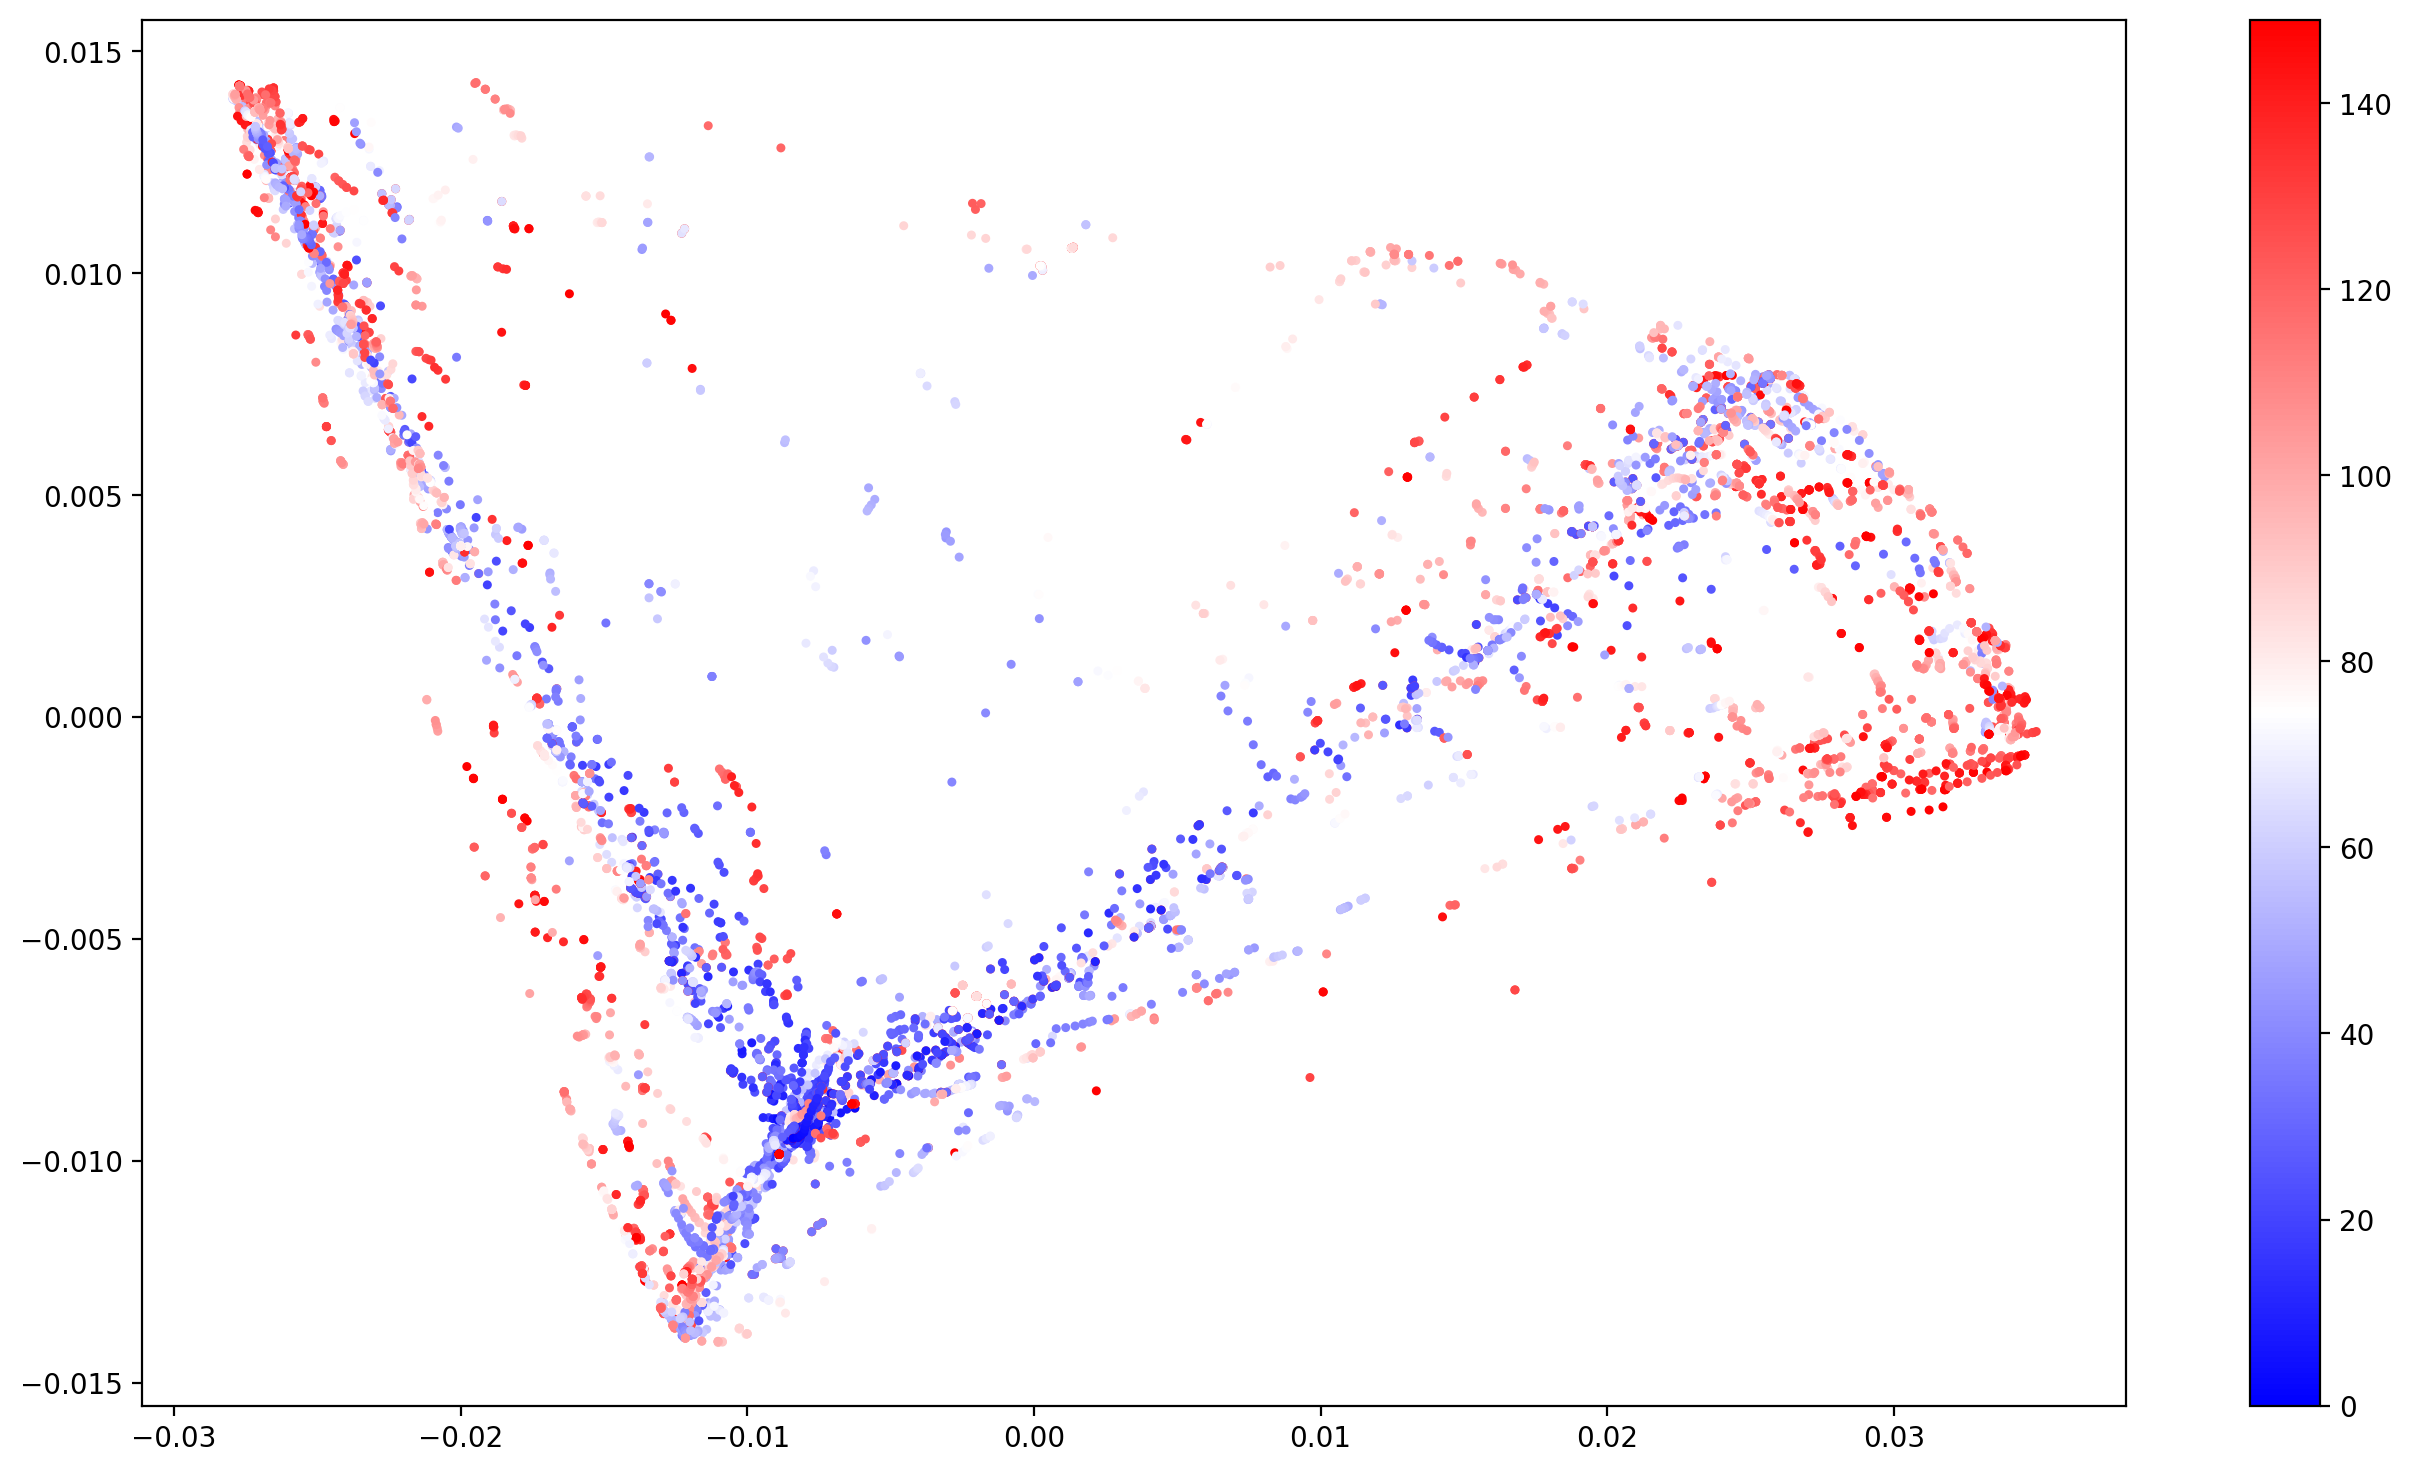

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=200)

for i in range(0, N_traj):
    offset=0
    for j in range(0, i-1):
        offset+=len(all_states[j])
    #im  = ax.plot(*embedding[offset:offset+len(all_states[i]), :].T, color="k", lw=0.01)
    im  = ax.scatter(*embedding[offset:offset+len(all_states[i]), :].T, s=5,
                     c=np.arange(0, len(all_states[i]), 1), cmap="bwr")

plt.colorbar(im)
plt.show()
#plt.savefig("evo_tree_8peaks_100_traj_PHATE.png")

# from PHATE

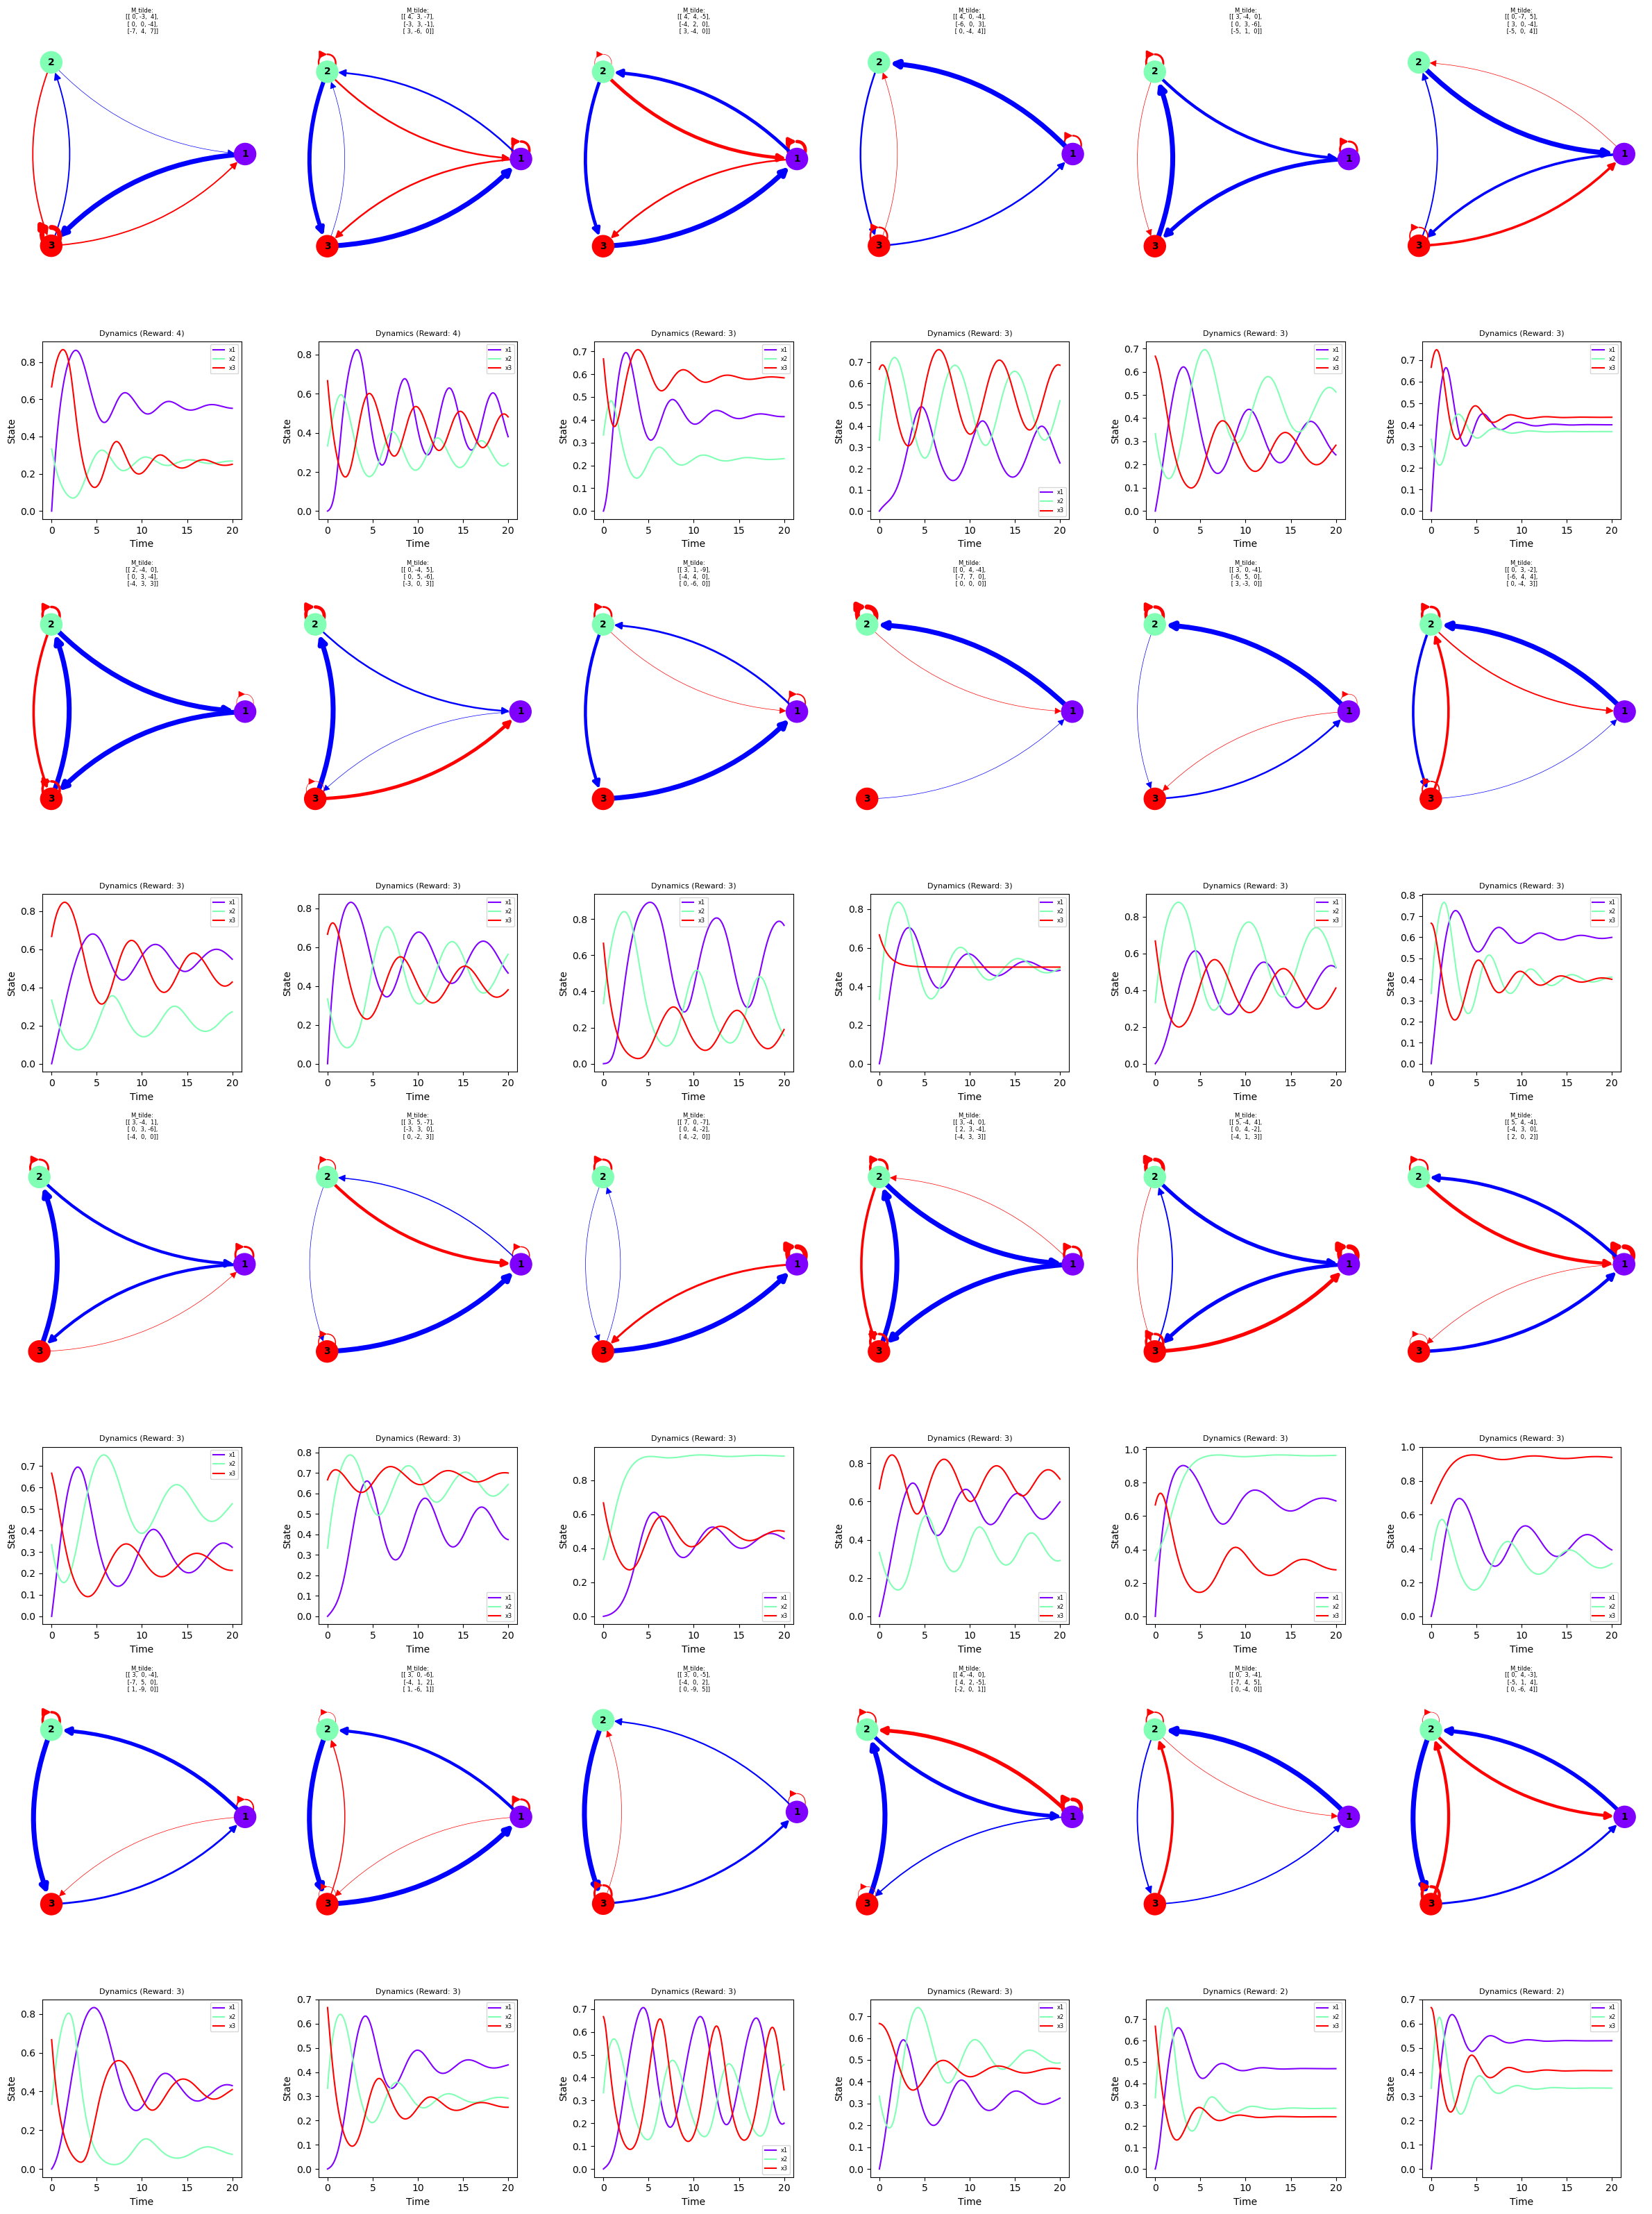

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def node_system_with_sigmoid(x, t, coord):
    matrix_dim = len(x)
    M_tilde = np.reshape(coord, (matrix_dim, matrix_dim))
    z = M_tilde.dot(x)
    sigmoid_z = sigmoid(z)
    dxdt = sigmoid_z - x
    return dxdt

def reward_oscillator(coord, ndim):
    delta = 0.0001
    matrix_dim = int(np.sqrt(ndim))
    xinit = np.linspace(0, 1, matrix_dim, endpoint=False)
    t = np.linspace(0, 20, 200)
    sol = odeint(node_system_with_sigmoid, xinit, t, args=(coord,))
    
    x1 = sol[:, 0]
    dx1 = np.diff(x1)
    x1_peaks = 0
    for j in range(1, len(dx1)):
        if dx1[j-1] > 0 and dx1[j] < 0:
            sharpness = x1[j] - (x1[j-1] + x1[j+1]) / 2
            if sharpness > delta:
                x1_peaks += 1
    
    return x1_peaks if x1_peaks > 0 else 0



def draw_network_motif(num_nodes, weights, reward, ax):
    weight_matrix = np.array(weights).reshape(num_nodes, num_nodes)
    
    G = nx.DiGraph()
    node_colors = plt.cm.rainbow(np.linspace(0, 1, num_nodes))
    
    G.add_nodes_from(range(1, num_nodes + 1))
    
    edge_colors_dict = {}
    edge_widths_dict = {}
    for i in range(num_nodes):
        for j in range(num_nodes):
            if weight_matrix[i, j] != 0:
                edge = (j + 1, i + 1)
                G.add_edge(*edge, weight=weight_matrix[i, j])
                edge_colors_dict[edge] = 'blue' if weight_matrix[i, j] < 0 else 'red'
                edge_widths_dict[edge] = abs(weight_matrix[i, j])
    
    edge_colors = [edge_colors_dict[edge] for edge in G.edges]
    edge_widths = [edge_widths_dict[edge] for edge in G.edges]
    
    if edge_widths:
        min_width = min(edge_widths)
        max_width = max(edge_widths)
        if min_width != max_width:
            edge_widths = [0.1 + 5 * ((width - min_width) / (max_width - min_width)) for width in edge_widths]
        edge_widths = [max(width, 0.5) for width in edge_widths]  # Ensure minimum visibility
    
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax, with_labels=True, node_size=NODE_SIZE, node_color=node_colors, font_size=10, font_weight='bold', 
            arrows=True, arrowsize=15, edge_color=edge_colors, width=edge_widths, connectionstyle="arc3,rad=0.2")

def plot_dynamical_system(weights, ax):
    ndim = len(weights)
    matrix_dim = int(np.sqrt(ndim))
    x0 = np.linspace(0, 1, matrix_dim, endpoint=False)
    t = np.linspace(0, 20, 200)
    sol = odeint(node_system_with_sigmoid, x0, t, args=(weights,))
    
    node_colors = plt.cm.rainbow(np.linspace(0, 1, matrix_dim))
    for i in range(matrix_dim):
        ax.plot(t, sol[:, i], label=f'x{i+1}', color=node_colors[i])
    
    ax.set_xlabel('Time')
    ax.set_ylabel('State')
    ax.legend(fontsize=DYNAMICS_LEGEND_FONT_SIZE)


        
def plot_motif_and_dynamics(weights_list):
    motifs_per_row = MOTIF_PER_ROW
    num_nodes = int(np.sqrt(len(weights_list[0])))
    num_motifs = len(weights_list)
    num_rows = (num_motifs + motifs_per_row - 1) // motifs_per_row
    fig, axs = plt.subplots(2 * num_rows, motifs_per_row, figsize=(PLOT_WIDTH_PER_MOTIF * motifs_per_row, PLOT_HEIGHT * num_rows))
    
    for i, weights in enumerate(weights_list):
        row = (i // motifs_per_row) * 2
        col = i % motifs_per_row
        
        ndim = len(weights)
        matrix_dim = int(np.sqrt(ndim))
        M_tilde = np.reshape(weights, (matrix_dim, matrix_dim))
        reward = reward_oscillator(weights, ndim)
        
        # Plot network motif
        draw_network_motif(num_nodes, weights, reward, axs[row, col])
        
        # Add M_tilde as text above the motif plot
        M_tilde_str = np.array2string(M_tilde, separator=', ', prefix='', suffix='')
        axs[row, col].text(0.5, 1.1, f"M_tilde:\n{M_tilde_str}", 
                    horizontalalignment='center', verticalalignment='center', 
                    transform=axs[row, col].transAxes, fontsize=MOTIF_TEXT_FONT_SIZE, wrap=True)
        
        # Plot dynamical system
        dynamics_ax = axs[row+1, col].inset_axes([0.1, 0.1, 0.8, 0.8])  # Create a smaller, centered subplot
        plot_dynamical_system(weights, dynamics_ax)
        dynamics_ax.set_title(f'Dynamics (Reward: {reward})', fontsize=DYNAMICS_TITLE_FONT_SIZE)
        axs[row+1, col].axis('off')  # Turn off the outer axes

    # Remove unused subplots
    for i in range(num_motifs, num_rows * motifs_per_row):
        row = (i // motifs_per_row) * 2
        col = i % motifs_per_row
        fig.delaxes(axs[row, col])
        fig.delaxes(axs[row+1, col])

    plt.tight_layout()
    plt.show()



# Example weights list
weights_list = [
[0, -3, 4, 0, 0, -4, -7, 4, 7], 
[4, 3, -7, -3, 3, -1, 3, -6, 0], 
[4, 4, -5, -4, 2, 0, 3, -4, 0], 
[4, 0, -4, -6, 0, 3, 0, -4, 4], 
[3, -4, 0, 0, 3, -6, -5, 1, 0], 
[0, -7, 5, 3, 0, -4, -5, 0, 4], 
[2, -4, 0, 0, 3, -4, -4, 3, 3], 
[0, -4, 5, 0, 5, -6, -3, 0, 3], 
[3, 1, -9, -4, 4, 0, 0, -6, 0], 
[0, 4, -4, -7, 7, 0, 0, 0, 0], 
[3, 0, -4, -6, 5, 0, 3, -3, 0], 
[0, 3, -2, -6, 4, 4, 0, -4, 3], 
[3, -4, 1, 0, 3, -6, -4, 0, 0], 
[3, 5, -7, -3, 3, 0, 0, -2, 3], 
[7, 0, -7, 0, 4, -2, 4, -2, 0], 
[3, -4, 0, 2, 3, -4, -4, 3, 3], 
[5, -4, 4, 0, 4, -2, -4, 1, 3], 
[5, 4, -4, -4, 3, 0, 2, 0, 2], 
[3, 0, -4, -7, 5, 0, 1, -9, 0], 
[3, 0, -6, -4, 1, 2, 1, -6, 1], 
[3, 0, -5, -4, 0, 2, 0, -9, 5], 
[4, -4, 0, 4, 2, -5, -2, 0, 1], 
[0, 3, -4, -7, 4, 5, 0, -4, 0], 
[0, 4, -3, -5, 1, 4, 0, -6, 4], 
]

# Plot configuration parameters
MOTIF_PER_ROW = 6
PLOT_HEIGHT = 8
PLOT_WIDTH_PER_MOTIF = 4
MOTIF_TEXT_FONT_SIZE = 6
DYNAMICS_TITLE_FONT_SIZE = 8
DYNAMICS_LEGEND_FONT_SIZE = 6
NODE_SIZE = 500
 
# Plot motifs and dynamics
plot_motif_and_dynamics(weights_list)



In [14]:
# Load successful trajectories from the pickle file
with open("successful_trajectories_3nodes_360found_reward3.pkl", "rb") as f:
    successful_trajectories = pickle.load(f)

# Print the length of successful_trajectories
print(f"Number of successful trajectories: {len(successful_trajectories)}")

Number of successful trajectories: 360


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import imageio
    

def create_frames(trajectory):
    frames = []
    for frame, appearance in enumerate(trajectory):
        fig, (ax_dynamics, ax_motif) = plt.subplots(2, 1, figsize=(6, 10))
        ax_dynamics.set_xlabel('Time')
        ax_dynamics.set_ylabel('State')
        ax_dynamics.set_title(f"Appearance {frame+1}: Reward {appearance_reward(appearance)}")
        ax_dynamics.legend()
        ax_dynamics.grid(True)      
        weights = np.array(draw_appearance(appearance)) 
        reward = appearance_reward(appearance)
        # Plot dynamics
        plot_dynamical_system(weights, ax_dynamics)
        # Plot motif
        draw_network_motif(n_node, weights, reward, ax_motif)
        
        # Save the current frame
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
        plt.close(fig)
    return frames

# Create the frames
if successful_trajectories[100]:
    frames = create_frames(successful_trajectories[100])
    # Save as an MP4 file
    imageio.mimsave('dynamical_system_with_motif.mp4', frames, fps=1)
else:
    print("No trajectory to plot.")

/tmp/ipykernel_1202111/1593518909.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_dynamics.legend()
/tmp/ipykernel_1202111/1593518909.py:25: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 1000) to (608, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6fb22c0] Warning: data is not aligned! This can lead to a speed loss


In [78]:
"""core trajectory intersection"""


import numpy as np

# Count occurrences of each matrix
matrix_counts = {}
for trajectory in weights_trajectories:
    for matrix in trajectory:
        matrix_str = str(matrix)  # Convert matrix to string for comparison
        if matrix_str in matrix_counts:
            matrix_counts[matrix_str] += 1
        else:
            matrix_counts[matrix_str] = 1

# Get the top 10 most common matrices
top_80_matrices = sorted(matrix_counts.items(), key=lambda x: x[1], reverse=True)[:80]

print("Top 80 most common intersection matrices:")
for i, (matrix_str, count) in enumerate(top_80_matrices, 1):
    print(f"\nRank {i}: Visited {count} times")
    print(np.array(eval(matrix_str)))  # Convert string back to numpy array for printing

Top 80 most common intersection matrices:

Rank 1: Visited 362 times
[0 0 0 0 0 0 0 0 0]

Rank 2: Visited 19 times
[4 0 0 0 0 0 0 0 0]

Rank 3: Visited 16 times
[0 0 0 0 3 0 0 0 0]

Rank 4: Visited 16 times
[ 0  0  0  0  0 -4  0  0  0]

Rank 5: Visited 12 times
[2 0 0 0 0 0 0 0 0]

Rank 6: Visited 12 times
[ 0  0  0  0  0  0  0 -4  0]

Rank 7: Visited 12 times
[ 0  0  0  0  0  0 -3  0  0]

Rank 8: Visited 12 times
[0 0 0 0 0 0 0 0 4]

Rank 9: Visited 11 times
[0 0 0 0 4 0 0 0 0]

Rank 10: Visited 10 times
[ 0  0  0  0  0 -1  0  0  0]

Rank 11: Visited 10 times
[ 0  0  0  0  0  0 -4  0  0]

Rank 12: Visited 10 times
[ 0 -3  0  0  0  0  0  0  0]

Rank 13: Visited 10 times
[0 0 0 0 0 0 0 0 3]

Rank 14: Visited 10 times
[ 0  0  0  0  0  0  0 -3  0]

Rank 15: Visited 9 times
[0 0 0 0 2 0 0 0 0]

Rank 16: Visited 9 times
[ 0  0  0 -3  0  0  0  0  0]

Rank 17: Visited 9 times
[ 0  0 -4  0  0  0  0  0  0]

Rank 18: Visited 8 times
[0 0 0 0 0 0 0 0 1]

Rank 19: Visited 8 times
[ 0 -4  0  0  0  

In [77]:
len(matrix_counts)


3175

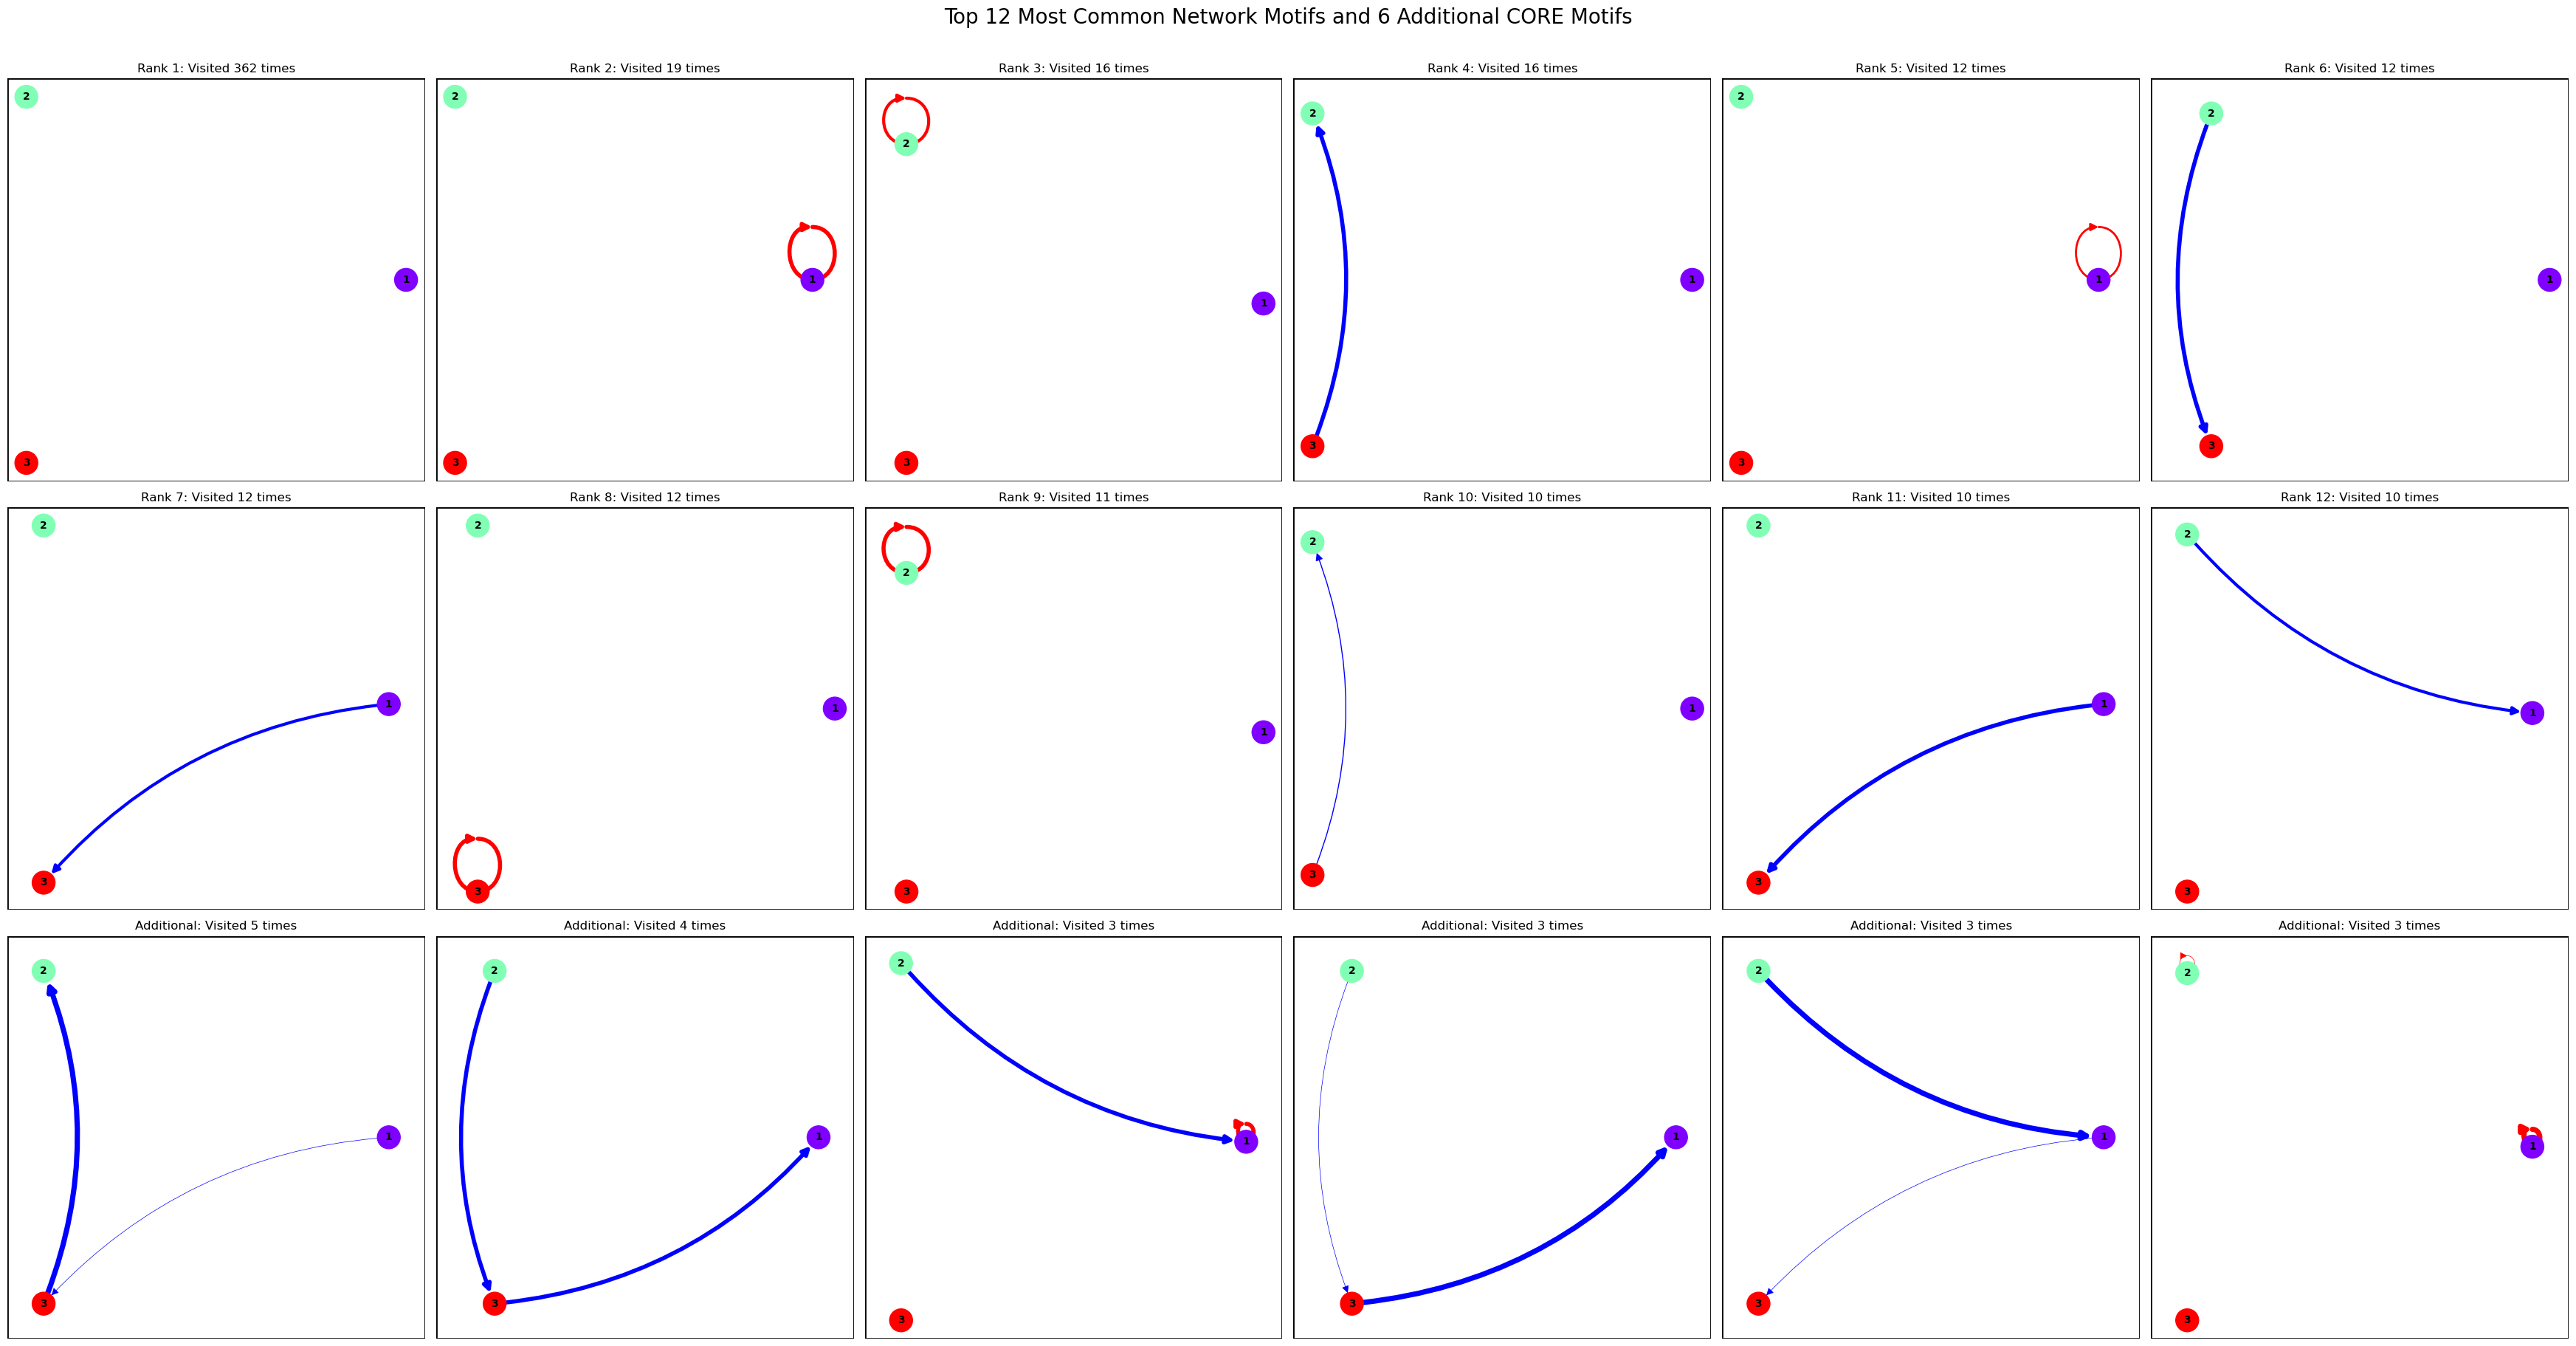

In [83]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

top_12_matrices = sorted(matrix_counts.items(), key=lambda x: x[1], reverse=True)[:12]
additional_matrices = [
    (str([0, 0, 0, 0, 0, -4, -3, 0, 0]), 5),
    (str([0, 0, -4, 0, 0, 0, 0, -4, 0]), 4),
    (str([4, -4, 0, 0, 0, 0, 0, 0, 0]), 3),
    (str([0, 0, -4, 0, 0, 0, 0, -3, 0]), 3),
    (str([0, -4, 0, 0, 0, 0, -2, 0, 0]), 3),
    (str([4, 0, 0, 0, 3, 0, 0, 0, 0]), 3)
]

fig, axes = plt.subplots(3, 6, figsize=(35, 18))  # Adjusted figure size for 3 rows
fig.suptitle('Top 12 Most Common Network Motifs and 6 Additional CORE Motifs', fontsize=20, y=1.01)  # Increased y value for higher spacing

all_matrices = top_12_matrices + additional_matrices

for i, (matrix_str, count) in enumerate(all_matrices):
    ax = axes[i // 6, i % 6]
    weights = eval(matrix_str)
    draw_network_motif(3, weights, count, ax)
    
    if i < 12:
        ax.set_title(f"Rank {i+1}: Visited {count} times")
    else:
        ax.set_title(f"Additional: Visited {count} times")
    
    # Add a rectangle around each subplot
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                     color='black', fill=False, linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()